# GP optimization

nuance requires a Gaussian Process (GP) of the light curve to be built and optimized before searching for transits.


In practice, any `tinygp.GaussianProcess` object can be provided. Here is an example of how to build and optimize a custom GP on the light curve of the active star [TOI 451](https://ui.adsabs.harvard.edu/abs/2021AJ....161...65N/abstract).

```{note}
This tutorial requires the `lightkurve` package to access the data
```

In order to run this tutorial on all available CPUs, we set the `XLA_FLAGS` env variable to

In [1]:
import os
import jax

jax.config.update("jax_enable_x64", True)
os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

## Loading data

As in previous tutorials, we will download light curves of TOI 451 using the `lightkurve` package.

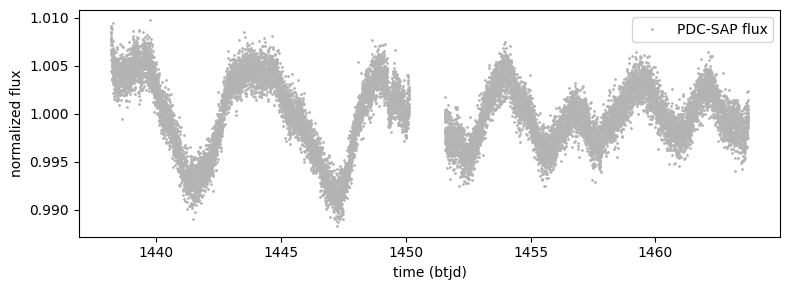

In [2]:
import matplotlib.pyplot as plt
import lightkurve as lk
import numpy as np

# single sector
lc = lk.search_lightcurve("TOI 451", author="SPOC", exptime=120)[1].download()

# masking nans
time = lc.time.to_value("btjd")
flux = lc.pdcsap_flux.to_value().filled(np.nan)
error = lc.flux_err.to_value().filled(np.nan)
mask = np.isnan(flux) | np.isnan(error) | np.isnan(time)
time = time[~mask].astype(float)
flux = flux[~mask].astype(float)
error = error[~mask].astype(float)

# normalize
flux_median = np.median(flux)
flux /= flux_median
error /= flux_median

# plot
plt.figure(figsize=(8, 3))
plt.plot(time, flux, ".", c="0.7", ms=2, label="PDC-SAP flux")
plt.xlabel("time (btjd)")
plt.ylabel("normalized flux")
plt.legend()
plt.tight_layout()

This star shows a clear stellar variability that needs to be modeled (but not removed) before searching for transits. In nuance stellar variability is modeled using a GP.

## Identify rotation period

Even though the rotation period of the star will be a hyperparameter of the GP, it is useful to have a rough estimate of it. For that we will build a simple Lomb-Scargle periodogram.

In [3]:
def rotation_period(time, flux):
    """rotation period based on LS periodogram"""
    from astropy.timeseries import LombScargle

    ls = LombScargle(time, flux)
    frequency, power = ls.autopower(minimum_frequency=1 / 10, maximum_frequency=1 / 0.1)
    period = 1 / frequency[np.argmax(power)]
    return period


period = rotation_period(time, flux)
print(f"P = {period:.3f} days")

P = 4.955 days


## Defining a GP

The next step consists in choosing an appropriate kernel and define a `build_gp` function to build our `tinygp.GaussianProcess` object.

Here we choose to implement a simple Damped Harmonic Oscillator kernel (SHO), probably not completely representative of the stellar variability of TOI 451, but sufficient for the purpose of this tutorial.

In [4]:
import jax.numpy as jnp
from tinygp import kernels, GaussianProcess

initial_params = {
    "log_period": jnp.log(period),
    "log_Q": jnp.log(100),
    "log_sigma": jnp.log(1e-1),
    "error": np.mean(error),
}


def build_gp(params, time):

    kernel = kernels.quasisep.SHO(
        jnp.exp(params["log_sigma"]),
        jnp.exp(params["log_period"]),
        jnp.exp(params["log_Q"]),
    )

    return GaussianProcess(kernel, time, diag=params["error"] ** 2, mean=1.0)

Note that we set the `mean` of the GP to 0, as nuance include a baseline model by default.

In order to optimize the GP, we compute the negative log likelihood of the GP on the light curve and minimize it using the `scipy.optimize.minimize` function.

In [5]:
from nuance.core import gp_model
from nuance.utils import minimize

mu, nll = gp_model(time, flux, build_gp)
params = minimize(nll, initial_params)

Let's plot the results

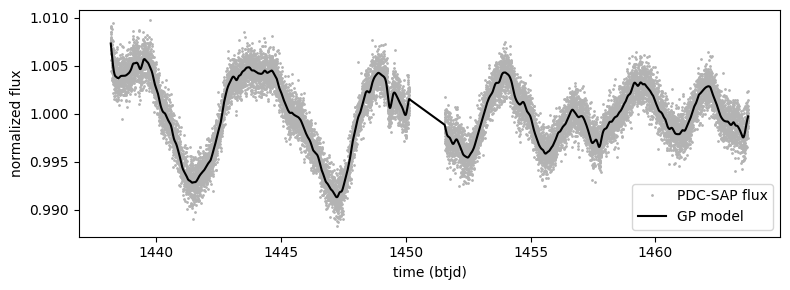

In [6]:
plt.figure(figsize=(8, 3))
plt.plot(time, flux, ".", c="0.7", ms=2, label="PDC-SAP flux")
plt.plot(time, mu(params), c="k", label="GP model")
plt.xlabel("time (btjd)")
plt.ylabel("normalized flux")
plt.legend()
plt.tight_layout()

That's it, you can now use this model to search for transit while accounting for stellar variability. Next step would be to clean for flares and define a more robust systematics model.